# Minimal Viable Product:

## An Analysis Of NYC 311 Data

As part of their open data project, New York City post data from a variety of Departments and other Government Entities. This project takes data from the NYC 311 Open Data set and attempts to predict future outcome of complaints.

<b> What is 311? </b><br>
311 was introduced as a non-emergency alternative to 911 in 1996 to help overwhelmed police emergency calls by providing citizens with an alternative three digit call number to voice complaints.

311 use in NYC has seen explosive growth since tracking was first introduced in 2003. Growing from approximitely 4.5 Million calls in it's first year to over 20million calls per year.

<b> Why look at 311?</b><br> 
311 is a unique attempt by governments to be more responsive to their citizens concerns. 311 complaints vary widely from noise complaints to mental health services. Yet many people have never used 311. Often the response is "it won't get fixed anyways, what's the point?" 

This project seeks to identify exactly causes a 311 complaint to be repsonded to faster than another. The project will attempt to predict new 311 calls close time to answer a fundemental question:<br>
<b><u> Can 311 Fix It? </b></u>

Citizens belief in institutions is fundamental in their success. 311 is simply a tool, how it works and we use it determins it's effectiveness. 

In [357]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<b>I've hidden the code by default for easier reading.
To toggle on/off the raw code,</b><br> click <a href="javascript:code_toggle()">here</a>.''')

In [9]:
ls

cleaning.py
dashboard.py
ec2-18-223-100-136.us-east-2.compute.amazonaws.com
mapping.py
noise_311.html
noise_complaints_flagged.html
__pycache__/
testing.py


In [81]:
#Normally needed libaries
import os
import math
import pandas as pd
import numpy as np
#Socrata is NYC's API
from sodapy import Socrata
import json
#Plotting libaries Folium & Plotly
import matplotlib.pyplot as plt
import folium
from folium import plugins
from folium.plugins import HeatMap
from folium.plugins import MarkerCluster
from plotly import tools
import plotly.plotly as py
import plotly.graph_objs as go
from IPython.display import HTML

#Import scripts I wrote to simplify code in the notebook
from cleaning import *
from mapping import *

In [11]:
%load_ext autoreload
%autoreload 2

## Initial Exploritory Data Analysis

In [12]:
sodapy_token = 'tvPeTjPatFwjuelfpMNb0G8WH'
sodapy_domain = 'data.cityofnewyork.us'
client = Socrata(sodapy_domain, sodapy_token)
database_311 = "fhrw-4uyv"
query = "created_date > '2017-01-01T13:00:00.000'"

In [13]:
# Limit the initial data set to 100k for easier handeling.
results = client.get(database_311, where=query
                     , limit=100000)
df = pd.DataFrame.from_records(results)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 41 columns):
address_type                      99620 non-null object
agency                            100000 non-null object
agency_name                       100000 non-null object
bbl                               88981 non-null object
borough                           100000 non-null object
bridge_highway_direction          234 non-null object
bridge_highway_name               234 non-null object
bridge_highway_segment            234 non-null object
city                              99995 non-null object
closed_date                       98431 non-null object
community_board                   100000 non-null object
complaint_type                    100000 non-null object
created_date                      100000 non-null object
cross_street_1                    60321 non-null object
cross_street_2                    60185 non-null object
descriptor                        99567 non-null o

<b>Initially we drop bridge information along with landmarks and road ramps because of their small contribution to the set as well as not entirely accurate in some cases</b>

In [15]:
DROP = ['bridge_highway_direction','bridge_highway_name',
       'bridge_highway_segment', 'landmark','road_ramp']

In [16]:
api_df = df.copy()

In [17]:
##mostly highway litter issues for bridge_* columns
api_df['descriptor'][api_df['bridge_highway_direction'].notnull()].head()

## interesting- location data maybe since are landmarks..but really not that many
api_df[api_df['landmark'].notnull()].count()

##Two non-null out of 100k...
# api_df[api_df['vehicle_type'].notnull()]

api_df[api_df['road_ramp'].notnull()]

## Neighborhoods - probably better way to define
print('number of unique entires in "city": {}'.format(api_df['city'].nunique()))

number of unique entires in "city": 89


In [18]:
print("Number of Unique Latitude locations: {}".format(api_df['latitude'].nunique()))
print("Number of Unique Longitude locations: {}".format(api_df['longitude'].nunique()))


Number of Unique Latitude locations: 54618
Number of Unique Longitude locations: 54618


In [19]:
## Drop unneeded columns
api_df.drop(DROP, axis=1,inplace=True)

<b>We can drop city simply because we have useful location data represented in Latitude/Longitude</b>

In [20]:
##Can we drop agency vs agency_name? 
api_df['agency'].nunique() # 16
api_df['agency_name'].nunique() # 115
api_df['agency'].value_counts()
# print(api_df['agency_name'].value_counts())

## Interesting- might be able to get more specific for sub agency level.
## Consider combinging both columns

HPD      31139
NYPD     29079
DSNY     13713
DOT       8533
DEP       8449
DOB       3090
DOHMH     2279
DPR       1462
TLC        932
DCA        675
DHS        405
DOE        101
DOF         97
EDC         23
DOITT       12
DFTA         9
FDNY         2
Name: agency, dtype: int64

In [21]:
## Null closed dates. These are pending assignment. Drops
# api_df[api_df['closed_date'].isnull()]
api_df.dropna(subset=['closed_date'],inplace=True)

<b>We drop any 'closed_date' that are empty, as we're interested in gettting only completed data</b>

In [22]:
api_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98431 entries, 0 to 99998
Data columns (total 36 columns):
address_type                      98058 non-null object
agency                            98431 non-null object
agency_name                       98431 non-null object
bbl                               87709 non-null object
borough                           98431 non-null object
city                              98426 non-null object
closed_date                       98431 non-null object
community_board                   98431 non-null object
complaint_type                    98431 non-null object
created_date                      98431 non-null object
cross_street_1                    59044 non-null object
cross_street_2                    58908 non-null object
descriptor                        98022 non-null object
due_date                          37767 non-null object
facility_type                     98431 non-null object
incident_address                  91331 non-null ob

<b>After looking at columns, decided to drop quite a few that were either small contributors or copies of information from other columns

We then drop anything missing in the 'descriptor' column<b>

In [23]:
# Let's get some general data going. Drops below are only for easier reading sake
DROP2 = [ 'agency_name','city','cross_street_1', 'cross_street_2',
          'facility_type', 'incident_address','intersection_street_1', 'intersection_street_2', 
         'location', 'location_type', 'park_borough', 'park_facility_name', 'street_name','taxi_company_borough', 'taxi_pick_up_location', 'unique_key',
       'x_coordinate_state_plane', 'y_coordinate_state_plane','due_date','bbl','vehicle_type']
#Come back for Latitude & Longitiude
DROP3 = ['address_type','incident_zip','resolution_action_updated_date','resolution_description','longitude','latitude']

In [24]:
api_df.drop(DROP2,axis=1, inplace=True)
api_df.drop(DROP3,axis=1, inplace=True)

In [25]:
#drop null descriptor
api_df.dropna(subset=['descriptor'],inplace=True)

In [26]:
api_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98022 entries, 0 to 99998
Data columns (total 9 columns):
agency                    98022 non-null object
borough                   98022 non-null object
closed_date               98022 non-null object
community_board           98022 non-null object
complaint_type            98022 non-null object
created_date              98022 non-null object
descriptor                98022 non-null object
open_data_channel_type    98022 non-null object
status                    98022 non-null object
dtypes: object(9)
memory usage: 7.5+ MB


<b>What we are left with is key items that we need going forward!</b>

In [27]:
print("Number of Community Boards: {}".format(api_df['community_board'].nunique())) 
#76, but only 59 community boards?
# api_df['community_board'].value_count

Number of Community Boards: 74


<b>Interesting, there are only 59 community boards in NYC. Researching this we find some odd inputs that are either undefined or incorrect. For right now we simply remove them for simplicity sake, but there are ways to get them included back in.</b>

In [28]:
# api_df[api_df['community_board']=='26 BRONX'] # most are in community board Bronx_8 need to clean this up- can use zip to determin?
# api_df[api_df['community_board']=='Unspecified MANHATTAN'] #find location numbers to get attached into
community_board_list = {'06 BRONX', '01 BRONX', '14 QUEENS', '13 QUEENS',
        '13 BROOKLYN', '09 BROOKLYN', '10 QUEENS',
       '08 BRONX', '10 BRONX', '01 QUEENS', '11 QUEENS', '01 BROOKLYN',
       '12 BRONX', '14 BROOKLYN', '07 MANHATTAN', '04 MANHATTAN',
       '05 MANHATTAN', '07 BRONX', '06 QUEENS', '18 BROOKLYN',
       '02 STATEN ISLAND', '15 BROOKLYN', '07 QUEENS', '03 STATEN ISLAND',
       '03 QUEENS', '08 QUEENS', '01 STATEN ISLAND', '07 BROOKLYN',
       '04 BRONX', '12 BROOKLYN', '12 QUEENS',
       '17 BROOKLYN', '04 QUEENS', '03 BROOKLYN', '05 QUEENS',
       '02 QUEENS', '03 MANHATTAN', '11 BRONX', '10 BROOKLYN',
       '06 BROOKLYN', '11 BROOKLYN', '05 BROOKLYN', '04 BROOKLYN',
       '12 MANHATTAN', '09 QUEENS', '09 MANHATTAN', '10 MANHATTAN',
       '16 BROOKLYN', '09 BRONX', '05 BRONX', '02 BROOKLYN',
       '06 MANHATTAN', '02 BRONX', '08 BROOKLYN', '11 MANHATTAN',
       '08 MANHATTAN', '02 MANHATTAN',  '03 BRONX',
       '01 MANHATTAN'}
# len(community_board_list) # perfect there are 59 community board

In [52]:
#drop anything not identified as a community board for right now...
api_df_cleaned = api_df[api_df['community_board'].isin(community_board_list)]

In [53]:
print("Number of Community Boards: {}".format(api_df_cleaned['community_board'].nunique()))

Number of Community Boards: 59


<b>That's better

Now we move into only considering calls with a 'status' of Closed. </b>

In [54]:
api_df_cleaned = api_df_cleaned[api_df_cleaned['status'] == 'Closed']

In [55]:
#drop status as we're not considering it anymore
api_df_cleaned.drop('status',axis=1,inplace=True)

In [57]:
print(api_df_cleaned.info()) # finally lets find outliers in our predictions

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95457 entries, 0 to 99998
Data columns (total 8 columns):
agency                    95457 non-null object
borough                   95457 non-null object
closed_date               95457 non-null object
community_board           95457 non-null object
complaint_type            95457 non-null object
created_date              95457 non-null object
descriptor                95457 non-null object
open_data_channel_type    95457 non-null object
dtypes: object(8)
memory usage: 6.6+ MB
None


<b>Now we want to know the time for resolution. This involves taking advantage of some pandas functions, which we'll add a column for how long it takes to close each case:</b>

In [70]:
created = pd.to_datetime(api_df_cleaned['created_date'],utc=True)
closed = pd.to_datetime(api_df_cleaned['closed_date'],utc=True)
api_df_cleaned['time_till_resolution'] =created - closed
api_df_cleaned['time_till_resolution'] =(-round(
    api_df_cleaned['time_till_resolution'].astype('timedelta64[s]')/3600,
        2))

In [71]:
#Don't need the close date anymore
api_df_cleaned.drop('closed_date', axis=1 , inplace=True)

In [72]:
api_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95457 entries, 0 to 99998
Data columns (total 8 columns):
agency                    95457 non-null object
borough                   95457 non-null object
community_board           95457 non-null object
complaint_type            95457 non-null object
created_date              95457 non-null object
descriptor                95457 non-null object
open_data_channel_type    95457 non-null object
time_till_resolution      95457 non-null float64
dtypes: float64(1), object(7)
memory usage: 6.6+ MB


In [73]:
print('Average number of hours to close a complaint: {}'.format(
    api_df_cleaned['time_till_resolution'].median()))

Average number of hours to close a complaint: 33.52


In [179]:
api_df_cleaned.agency.unique()

array(['DEP', 'NYPD', 'DSNY', 'DOT', 'DOHMH', 'DCA', 'DOB', 'DPR', 'HPD',
       'DHS', 'TLC', 'DOF', 'DOE', 'DFTA', 'EDC', 'DOITT'], dtype=object)

In [188]:
data =[]

In [189]:
for agency_name in api_df_cleaned.agency.unique():
    agency_name = go.Box(
    y=list(api_df_cleaned[api_df_cleaned['agency'] == agency_name]['time_till_resolution']),
    name = agency_name)
    data.append(agency_name)
    

In [190]:
py.iplot(data, filename='histogram')

16

In [164]:
y0

array([-0.8418291 , -1.93436027,  0.11692777, -0.39251596, -1.28304431,
        0.95048403, -0.58317534, -1.70594487, -2.16068073, -1.09341906,
       -1.86411763, -0.84613695, -0.57976081, -1.61684568, -0.21385243,
       -0.64603348, -1.2742121 ,  0.26648517, -2.29684028, -1.13890398,
       -3.13489127, -1.30612778, -0.53558572, -0.52916417,  0.88411044,
       -2.44720778,  0.27640579, -0.44771274, -2.67859746, -1.55985787,
        0.76112028, -0.41811477, -0.81957902, -1.29067725, -1.79959617,
       -1.97313028, -0.67255429, -0.06635451, -0.29169826,  0.08012704,
       -0.66454681, -1.16005707, -1.48244967, -1.56216843, -1.82518617,
       -0.83008231, -0.19089778, -0.68243631, -1.74190437, -0.11987924])

In [158]:
from numpy import * 

In [161]:
# Number of boxes

# generate an array of rainbow colors by fixing the saturation and lightness of the HSL representation of colour 
# and marching around the hue. 
# Plotly accepts any CSS color format, see e.g. http://www.w3schools.com/cssref/css_colors_legal.asp.
c = ['hsl('+str(h)+',50%'+',50%)' for h in np.linspace(0, 360, 16)]

# Each box is represented by a dict that contains the data, the type, and the colour. 
# Use list comprehension to describe N boxes, each with a different colour and with different randomly generated data:
data = [{
    'y':  
    'type':'box',
    'marker':{'color': c[i]}
    } for i in range(16)]

# format the layout
layout = {'xaxis': {'showgrid':False,'zeroline':False, 'tickangle':60,'showticklabels':False},
          'yaxis': {'zeroline':False,'gridcolor':'white'},
          'paper_bgcolor': 'rgb(233,233,233)',
          'plot_bgcolor': 'rgb(233,233,233)',
          }

py.iplot(data)

<b>Great, now we need to get dummy variables to run some regression models

In [37]:
api_df_cleaned['created_date']= pd.to_datetime(api_df_cleaned['created_date'])
api_df_cleaned['created_date_year'] = api_df_cleaned['created_date'].dt.year
api_df_cleaned['created_date_month'] = api_df_cleaned['created_date'].dt.month
api_df_cleaned['created_date_day'] = api_df_cleaned['created_date'].dt.day
api_df_cleaned['created_date_hour'] = api_df_cleaned['created_date'].dt.hour
api_df_cleaned['created_date_day_of_week'] = api_df_cleaned['created_date'].dt.dayofweek
api_df_cleaned.drop('created_date',axis=1,inplace=True)

In [38]:
api_df_cleaned = pd.get_dummies(api_df_cleaned, columns=['agency','borough','community_board',
                                      'complaint_type','descriptor','open_data_channel_type'])

<b>After getting dummies we end up with a matrix with 773 features and over 95k rows

In [39]:
api_df_cleaned.shape

(95457, 792)

<b>Now we'll run some models. Random Forest and Gradient Boost were picked because of their robustness to overfitting, as well as good out of the box results. We split the data to resevere about 30% for testing our results against

In [40]:
from sklearn.ensemble import RandomForestRegressor , GradientBoostingRegressor
from sklearn.model_selection import train_test_split

In [41]:
y = api_df_cleaned.pop('time_till_resolution')
X = api_df_cleaned
X_train, X_test , y_train, y_test = train_test_split(X,y, test_size = .3, random_state = 33)

<b>First we'll start with Random Forest</b>

In [42]:
random_forest = RandomForestRegressor()
random_forest.fit(X_train, y_train)
print('R2 score {}'.format(random_forest.score(X_test,y_test)))

R2 score 0.44354846811540893


In [47]:
RF_features = random_forest.feature_importances_
RF_incides = np.argsort(RF_features)[::-1]
RF_names = X_test.columns
RF_names[RF_incides][:10]
RF_features[RF_incides][:10]

array([0.09615088, 0.07987652, 0.06259358, 0.05980325, 0.05863774,
       0.05391233, 0.04793374, 0.03955846, 0.03651213, 0.02988723])

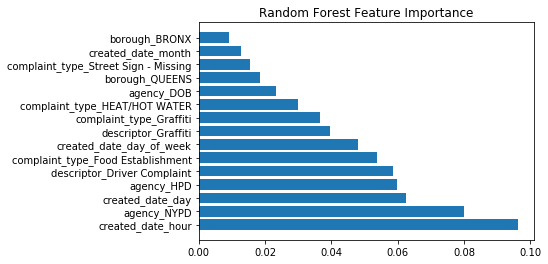

In [48]:
plt.barh(RF_names[RF_incides][:15],RF_features[RF_incides][:15])
plt.title('Random Forest Feature Importance');

<b>Now Gradient Boost</b>

In [43]:
gradient_boost = GradientBoostingRegressor()
gradient_boost.fit(X_train, y_train)
print('R2 score {}'.format(gradient_boost.score(X_test,y_test)))

R2 score 0.39716625268075123


In [44]:
GB_features = gradient_boost.feature_importances_
GB_incides = np.argsort(GB_features)[::-1]
GB_names = X_test.columns
GB_names[GB_incides][:10]
GB_features[GB_incides][:10]

array([0.09176581, 0.06528057, 0.04792355, 0.04589214, 0.04271178,
       0.04043932, 0.03520688, 0.02732476, 0.02612446, 0.02594278])

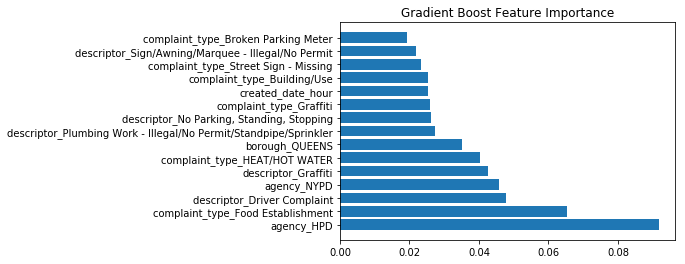

In [45]:
plt.barh(GB_names[GB_incides][:15],GB_features[GB_incides][:15])
plt.title('Gradient Boost Feature Importance');

<b>Overall our models didn't fit great. We may need to look into testing on more data. Feature importance leaned heavily on some connected components such as Agency & Complaint type, which seem to be related. 

<b>Let us move on to some interesting things from the data:

In [443]:
data_cleaner = DataCleaner()
data_cleaner.get_data('2018-08-10')

In [444]:
#Cleaned 311 Data with locations & dates
data_311 = data_cleaner.clean_data()
agency_calls = data_311['agency'].value_counts()

# Total Complaints In Each Borough 

In [445]:
boroughs = Map311()
boroughs.pie_chart(data_311,'borough')

##  Top Complaints By Borough

In [ ]:
total_by_borough = data_311.groupby('borough')['complaint_type'].value_counts()

In [ ]:
fig = tools.make_subplots(rows=2, cols=3, 
                          subplot_titles = ('Bronx','Manhattan','Staten Island'
                                           ,'Brooklyn','Queens','Unspecified')
                         )

In [ ]:
# total_by_borough

In [ ]:
row =1
col =1
for i in total_by_borough.index.levels[0]:
        if row > 2:
            row = 1
        sub_list = f[i][:7]
        trace = go.Bar(x = list(sub_list.index),
                       y=list(sub_list.values),name= i,
                      )
        fig.append_trace(trace , row, math.floor(col),)
        row+=1
        col+=.5

In [ ]:
fig['layout'].update(height=600, width=600, 
                     title='Top Complaints' +'By Borough')

py.iplot(fig, filename='customizing-subplot-axes')
# fig = go.Figure(data=data, layout=layout) 

### Complaint Totals by Agencies

In [ ]:
agency_total = go.Bar(x=agency_calls.index,
                      y=agency_calls.values,
                      text=['NY Police Dept','Sanitation Dept','Housing Dept',
                           'Transportation Dept','Enviromental Protection Dept',
                           'Buildings Dept','Parks & Rec Dept','Mental Health Dept',
                           'Consumer Affairs','Finance Dept', 'Taxi&Limo Commission',
                           'Economic Development Corp','Aging Dept','ITT Dept','Education Dept']
                     )
data = [agency_total]

In [ ]:
py.iplot(data, filename='Agency_Totals')

## Top Complaints

In [ ]:
noise_types = ['Noise - Street/Sidewalk','Noise - Vehicle','Noise - Residential','Noise - Commercial','Noise - Park','Noise - House of Worship','Collection Truck Noise']
sanitation = ['UNSANITARY CONDITION','Sanitation Condition','Dirty Conditions','Dirty Conditions']
complaint_dict = {}
for x in sanitation:
    complaint_dict[x] = 'Noise'


In [ ]:
data_311['complaint_type'].replace(complaint_dict, inplace=True)

In [ ]:


complaint_types = Map311()
complaint_types.bar_plot(data_311.complaint_type.value_counts(),'Top Complaints')

### Mapping Noise Complaints in NYC:

In [446]:
noise_data = data_311[data_311['complaint_type']=='Noise'][['latitude','longitude']].values

In [447]:
noise_311 = folium.Map(location=[40.757937,-73.882155], zoom_start=11,
                     tiles= "Stamen Terrain")

In [448]:
hm = plugins.HeatMap(noise_data,radius=15)
hm.add_to(noise_311)
noise_311

In [453]:
noise_311.save('noise_311.html')

cleaning.py  mapping.py  noise_311.html  __pycache__/  testing.py


In [ ]:
#Just created a class to do the above
noise.heat_map(data_311,'Noise')

### Mapping rodent sightings:

In [ ]:
rodent_data = data_311[data_311['complaint_type']=='Rodent'][['latitude','longitude']].values
map_311 = folium.Map(location=[40.757937,-73.882155], zoom_start=11,
                    tiles= "Stamen Terrain" )
map_311.add_child(MarkerCluster(rodent_data))

# Let's test out our model against unseen data:

In [4]:
cd scripts/


/home/pipingkid/Galvanize/Energy-NYCHA/scripts


In [201]:
import pickle
from testing import *
from sklearn.externals import joblib

In [202]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [203]:
predictions = PredictionsTable()

In [204]:
predictions.get_data()

In [205]:
predictions.clean_data()

In [206]:
predictions_dataframe = predictions.predict()

FileNotFoundError: [Errno 2] No such file or directory: '../EDA/random_forest_model.pkl'

### Create an SQL table for easy query for future storage and query

In [199]:
import sqlite3 
engine = sqlite3.connect("/home/pipingkid/Galvanize/Energy-NYCHA/sql_tables/predictions_311.db3")

In [200]:
predictions_dataframe.to_sql('predictions_311', con=engine, if_exists='append')

NameError: name 'predictions_dataframe' is not defined

In [232]:
unique_key = engine.execute("SELECT unique_key FROM predictions_311").fetchall()

In [240]:
unique_key = tuple([x[0] for x in unique_key])

In [259]:
unique_key

('40176158',
 '40173118',
 '40176183',
 '40172583',
 '40173801',
 '40172170',
 '40172000',
 '40176184',
 '40170877',
 '40175859',
 '40172012',
 '40173643',
 '40172153',
 '40172959',
 '40174563',
 '40174441',
 '40174744',
 '40173547',
 '40175986',
 '40175881',
 '40172956',
 '40175409',
 '40172155',
 '40173689',
 '40172067',
 '40173037',
 '40170524',
 '40175413',
 '40174402',
 '40174519',
 '40171483',
 '40173691',
 '40171918',
 '40170473',
 '40175946',
 '40172955',
 '40172853',
 '40174983',
 '40174440',
 '40172361',
 '40171062',
 '40176684',
 '40172958',
 '40172790',
 '40174536',
 '40175144',
 '40172146',
 '40171592',
 '40171265',
 '40172794',
 '40174277',
 '40171217',
 '40172123',
 '40175346',
 '40170649',
 '40171423',
 '40175188',
 '40171105',
 '40172866',
 '40174629',
 '40172854',
 '40172753',
 '40176248',
 '40171981',
 '40171993',
 '40172763',
 '40172906',
 '40171481',
 '40174466',
 '40171299',
 '40170523',
 '40171101',
 '40174602',
 '40173642',
 '40170814',
 '40170639',
 '40173753',

In [191]:
database_311 = "fhrw-4uyv"
client = Socrata('data.cityofnewyork.us', 'tvPeTjPatFwjuelfpMNb0G8WH')
        #Save memory initiall by quirying only that what is need:
select_sql = "unique_key,agency,borough,closed_date,community_board,complaint_type,created_date,descriptor,open_data_channel_type,status,longitude,latitude"

In [192]:
time = datetime.utcnow()-timedelta(days=2)
time_string = '{}-{}-{}T00:00:00.000'.format(time.year,time.month,time.day)
query = "closed_date > '{}' ".format(time_string)
results = client.get(database_311, select=select_sql, where=query, limit=1000)
data_frame = pd.DataFrame.from_records(results)

NameError: name 'datetime' is not defined

In [289]:
keys = data_frame[data_frame['unique_key'].isin(unique_key)].unique_key.values

In [286]:
actual = data_frame[data_frame['unique_key'].isin(unique_key)]

In [198]:
actual.set_index('unique_key')

NameError: name 'actual' is not defined

In [306]:
created = actual['created_date'] = pd.to_datetime(actual['created_date'])
closed = actual['closed_date'] = pd.to_datetime(actual['closed_date'])

/home/pipingkid/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/pipingkid/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [307]:
actual['Real_Time_To_Close'] = created - closed

/home/pipingkid/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [308]:
actual['Real_Time_To_Close']= (-round(
                                    actual['Real_Time_To_Close'].astype(
                                    'timedelta64[s]')/3600,2))

/home/pipingkid/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [317]:
actual.set_index('unique_key',inplace=True)

In [322]:
actual.sort_index(inplace=True)

/home/pipingkid/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [324]:
actual

,agency,borough,closed_date,community_board,complaint_type,created_date,descriptor,latitude,longitude,open_data_channel_type,status,Real_Time_To_Close
unique_key,,,,,,,,,,,,
40170512,NYPD,BROOKLYN,2018-09-03 03:10:05,08 BROOKLYN,Noise - Residential,2018-09-03 01:45:53,Loud Music/Party,40.67422507146952,-73.94829264674807,PHONE,Closed,1.40
40170624,NYPD,BROOKLYN,2018-09-03 03:04:52,08 BROOKLYN,Noise - Residential,2018-09-03 01:51:42,Loud Music/Party,40.671536273681525,-73.95765669143151,ONLINE,Closed,1.22
40170643,NYPD,BROOKLYN,2018-09-03 03:03:50,08 BROOKLYN,Noise - Residential,2018-09-03 02:11:00,Loud Music/Party,40.67229447522101,-73.94607349149379,ONLINE,Closed,0.88
40170644,NYPD,BROOKLYN,2018-09-03 03:09:04,08 BROOKLYN,Noise - Residential,2018-09-03 02:04:27,Loud Music/Party,40.673230720148354,-73.95295829419965,ONLINE,Closed,1.08
40170679,NYPD,MANHATTAN,2018-09-03 02:58:40,05 MANHATTAN,Noise - Residential,2018-09-03 00:48:31,Loud Music/Party,40.74379669398181,-73.98901113454961,PHONE,Closed,2.17
40170680,NYPD,BRONX,2018-09-03 03:14:15,09 BRONX,Noise - Residential,2018-09-03 01:23:05,Loud Music/Party,40.83030578736809,-73.87179244580001,PHONE,Closed,1.85
40171169,NYPD,BRONX,2018-09-03 03:14:15,09 BRONX,Noise - Street/Sidewalk,2018-09-03 00:25:04,Loud Music/Party,40.83108001242169,-73.8719860862214,PHONE,Closed,2.82
40171252,NYPD,BROOKLYN,2018-09-03 02:53:31,05 BROOKLYN,Noise - Residential,2018-09-03 02:11:19,Loud Music/Party,40.66280391078025,-73.88406312199135,PHONE,Closed,0.70
40171306,NYPD,BROOKLYN,2018-09-03 02:53:30,05 BROOKLYN,Noise - Residential,2018-09-03 01:35:48,Loud Music/Party,40.65988432748271,-73.8905487027545,PHONE,Closed,1.30


In [314]:
predicted.set_index('unique_key', inplace=True)

In [323]:
predicted.sort_index(inplace=True)

In [325]:
predicted['Actual_Time'] = actual['Real_Time_To_Close']

In [196]:
predicted.to_html('predicted.html')

NameError: name 'predicted' is not defined

In [197]:
predicted = pd.read_sql_query(sql="SELECT * FROM predictions_311 WHERE unique_key IN {}".format(tuple(keys)), con=sqlite3.connect("/home/pipingkid/Galvanize/Energy-NYCHA/sql_tables/predictions_311.db3"))

NameError: name 'keys' is not defined

## Find clusters of points to raise red flags:

In [12]:
from geopy.distance import great_circle , vincenty
from sklearn.cluster import DBSCAN
from datetime import datetime, timedelta

In [37]:
 # Domain , SODA API
database_311 = "fhrw-4uyv"
client = Socrata('data.cityofnewyork.us', 'tvPeTjPatFwjuelfpMNb0G8WH')
    #Save memory initiall by quirying only that what is need:
select_sql = "created_date,complaint_type,longitude,latitude"

In [172]:
time = datetime.utcnow()-timedelta(days=7)
time_string = '{}-{}-{}T00:00:00.000'.format(time.year,time.month,time.day)
query = "created_date > '{}' AND complaint_type LIKE '%Homeless%' ".format(time_string)
results = client.get(database_311, select=select_sql, where=query, limit=100000)
predictions_dataframe = pd.DataFrame.from_records(results)

In [173]:
predictions_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 578 entries, 0 to 577
Data columns (total 4 columns):
complaint_type    578 non-null object
created_date      578 non-null object
latitude          569 non-null object
longitude         569 non-null object
dtypes: object(4)
memory usage: 18.1+ KB


In [174]:
predictions_dataframe.complaint_type.value_counts()

Homeless Person Assistance    454
Homeless Encampment           124
Name: complaint_type, dtype: int64

In [175]:
coordinates = predictions_dataframe[['latitude', 'longitude']]
coordinates = coordinates.convert_objects(convert_numeric=True)
coordinates.dropna(inplace=True)

/home/pipingkid/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning:

convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.



In [176]:
coordinates.values[0][0]

40.70742887810631

In [63]:
def GreatCircleDistance(x, y):
    lat1, lon1 = x[0], x[1]
    lat2, lon2 = y[0], y[1]
    return great_circle((lat1, lon1), (lat2, lon2)).meters


In [64]:
#measure based upon great circle distance as Lat & Long have different measurments when it comes to euclidean 
great_circle(coordinates[:1].values,coordinates[1:2].values).meters

16774.390874480316

In [ ]:
#For noise complaints we'll stick to 50meters. Note this is extreamly subjective!

In [184]:
total = DBSCAN(eps=50, min_samples=5, metric=GreatCircleDistance, n_jobs=-1).fit(coordinates.values)

In [185]:
# outliers are -1, and clusters are everything from 0 on up
noise_complaints = pd.DataFrame(coordinates.values, columns=['Latitude', 'Longitude'])
len(total.labels_)

569

In [186]:
noise_complaints['label'] = total.labels_

In [180]:
noise_complaints[noise_complaints.label > -1].groupby('label').mean()

,Latitude,Longitude
label,,
0,40.737755,-73.996707
1,40.728634,-73.987941
2,40.766660,-73.986769
3,40.735434,-73.989696
4,40.746096,-73.982068
5,40.696254,-73.973632
6,40.743679,-73.983002
7,40.763668,-73.981586
8,40.776260,-73.982128


In [69]:
#plotting! 


In [187]:
NYC = [40.757937,-73.882155]
noise_means = noise_complaints[noise_complaints.label > -1].groupby('label').mean()
MAX_Count = len(noise_complaints[noise_complaints.label > -1].groupby('label').mean())

In [188]:
flag_noise = folium.Map(location=NYC , zoom_start=11)
for each in noise_means[0:MAX_Count].iterrows():
        folium.Marker(location = [each[1]['Latitude'],each[1]['Longitude']]).add_to(flag_noise)

In [189]:
# flag_noise.save('../noise_complaints_flagged.html')
flag_noise #More than 3 complaints within 50 meters of each other yesterday.

In [167]:
predictions_dataframe.complaint_type.value_counts()

Request Large Bulky Item Collection    3230
Name: complaint_type, dtype: int64

## RODENTS

In [12]:
from geopy.distance import great_circle , vincenty
from sklearn.cluster import DBSCAN
from datetime import datetime, timedelta

In [147]:
 # Domain , SODA API
database_311 = "fhrw-4uyv"
client = Socrata('data.cityofnewyork.us', 'tvPeTjPatFwjuelfpMNb0G8WH')
    #Save memory initiall by quirying only that what is need:
select_sql = "created_date,complaint_type,longitude,latitude"

In [148]:
time = datetime.utcnow()-timedelta(days=7)
time_string = '{}-{}-{}T00:00:00.000'.format(time.year,time.month,time.day)
query = "created_date > '{}' AND complaint_type LIKE '%Bulky%' ".format(time_string)
results = client.get(database_311, select=select_sql, where=query, limit=100000)
predictions_dataframe = pd.DataFrame.from_records(results)

In [149]:
predictions_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3230 entries, 0 to 3229
Data columns (total 4 columns):
complaint_type    3230 non-null object
created_date      3230 non-null object
latitude          3229 non-null object
longitude         3229 non-null object
dtypes: object(4)
memory usage: 101.0+ KB


In [130]:
predictions_dataframe.complaint_type.value_counts()

Rodent    454
Name: complaint_type, dtype: int64

In [150]:
coordinates = predictions_dataframe[['latitude', 'longitude']]
coordinates = coordinates.convert_objects(convert_numeric=True)
coordinates.dropna(inplace=True)

/home/pipingkid/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning:

convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.



In [132]:
coordinates.values[0][0]

40.819823775107935

In [151]:
def GreatCircleDistance(x, y):
    lat1, lon1 = x[0], x[1]
    lat2, lon2 = y[0], y[1]
    return great_circle((lat1, lon1), (lat2, lon2)).meters


In [152]:
#measure based upon great circle distance as Lat & Long have different measurments when it comes to euclidean 
great_circle(coordinates[:1].values,coordinates[1:2].values).meters

14432.175730714413

In [135]:
#For noise complaints we'll stick to 50meters. Note this is extreamly subjective!

In [161]:
total = DBSCAN(eps=50, min_samples=5, metric=GreatCircleDistance, n_jobs=-1).fit(coordinates.values)

In [162]:
# outliers are -1, and clusters are everything from 0 on up
noise_complaints = pd.DataFrame(coordinates.values, columns=['Latitude', 'Longitude'])
len(total.labels_)

3229

In [163]:
noise_complaints['label'] = total.labels_

In [157]:
#plotting! 


In [164]:
NYC = [40.757937,-73.882155]
noise_means = noise_complaints[noise_complaints.label > -1].groupby('label').mean()
MAX_Count = len(noise_complaints[noise_complaints.label > -1].groupby('label').mean())

In [165]:
flag_noise = folium.Map(location=NYC , zoom_start=11)
for each in noise_means[0:MAX_Count].iterrows():
        folium.Marker(location = [each[1]['Latitude'],each[1]['Longitude']]).add_to(flag_noise)

In [166]:
# flag_noise.save('../rodent_complaints_flagged.html')
flag_noise #More than 3 complaints within 50 meters of each other last 7 Days.

In [ ]:
predictions_dataframe.complaint_type.value_counts()

## Add to S3

In [144]:
import boto3
client = boto3.client('s3') #low-level functional API
resource = boto3.resource('s3') #high-level object-oriented API
my_bucket = resource.Bucket('capstone311-bucket') 

my_bucket.upload_file('../rodent_complaints_flagged.html', Key='rodent_flagged.html', ExtraArgs={'ACL':'public-read'})


In [ ]:
def fileId_from_url(url):
    """Return fileId from a url."""
    raw_fileId = re.findall("~[A-z]+/[0-9]+", url)[0][1: ]
    return raw_fileId.replace('/', ':')

In [ ]:
file_1 = fileId_from_url('https://plot.ly/~nickeloustex/8')

In [ ]:
file_1

In [ ]:
box_1 = {
    'type': 'box',
    'boxType': 'bar',
    'fileId': 'nickeloustex:8',
    'title': 'Complaints-By-Borough'
}
 
box_2 = {
    'type': 'box',
    'boxType': 'plot',
    'fileId': '8',
    'title': 'pie-for-dashboard'
}
 
box_3 = {
    'type': 'box',
    'boxType': 'plot',
    'fileId': 'PlotBot:1342',
    'title': 'box-for-dashboard',
    'shareKey':'uVoeGB1i8Xf4fk0b57sT2l'
}

In [ ]:
my_dboard.insert(box_1)

In [ ]:

my_dboard.get_preview()

For tomorrow:
Dashboard for rasing flags for top complaints by top agencies (based upon location)
Table view based on unique id 
Predict function based on complaint (issues with community board, agency, ect)
Avg times for complaints by department



## Dash

In [195]:
import dash
from dash.dependencies import Input, Output
import dash_core_components as dcc
import dash_html_components as html
# from pandas_datareader import data as web
from datetime import datetime as dt

app = dash.Dash()

app.layout = html.Div([
    html.H1('Stock Tickers'),
    dcc.Dropdown(
        id='my-dropdown',
        options=[
            {'label': 'Coke', 'value': 'COKE'},
            {'label': 'Tesla', 'value': 'TSLA'},
            {'label': 'Apple', 'value': 'AAPL'}
        ],
        value='COKE'
    ),
    dcc.Graph(id='my-graph')
])
